# Pair-level analyses
Through this notebook, we produce all visualizations of pairs' behavior at the pair-level, i.e., all the plots in our paper which do not report information on individual simulations. For simplicity, we collated all analyses for all three experiments in the same notebook.
Analyses focus both on performance metrics and on search dynamics.

In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
import json
import glob
import itertools
import random

### Preprocessing
To start with let's read in the aggregated data, reporting metrics in which we are in interested for our analysis.
We have generated these using `scripts/postprocess.py`.

In [2]:
PATH = "../metrics"

In [3]:
def _read_data():
    ds = []
    for n in [0, 1, 2]:
        for itype in ["strict", "flexible", "shortest"]:
            fname = f"aggregates_{itype}.tsv"
            d = pd.read_csv(f"{PATH}/{n}_back/{fname}", sep="\t")
            d.rename({"originality_gain_tot": "orig_gain_tot"}, axis=1, inplace=True)
            ds.append(d)
    return pd.concat(ds, ignore_index=True)

We add a few relevant metrics (relevant for plotting and visualization)

In [4]:
aggs = _read_data()
aggs["orig_mean"] = (aggs["orig_a0"] + aggs["orig_a1"]) / 2
aggs["fluency_ratio"] = aggs["fluency_pair"] / 240
aggs["fluency_ratio_individual"] = aggs["fluency_a0"] / 240

Finally, we split the dataset into one dataframe per experiment, for simplicity.

In [5]:
exp_1 = aggs[aggs["n_back"] == 0]
exp_1 = exp_1[exp_1["interaction_type"] == "strict"]
exp_1["diversity_level"] = exp_1["diversity_level"].astype(int)
exp_2 = aggs.copy()
exp_2 = aggs[aggs["n_back"] == 0]
exp_2["diversity_level"] = exp_2["diversity_level"].astype(int)
exp_3 = aggs.copy()
exp_3["diversity_level"] = exp_3["diversity_level"].astype(int)

/tmp/ipykernel_2506/38238843.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exp_2['diversity_level'] = exp_2['diversity_level'].astype(int)


One last thing to do before starting to analyse the data from Experiment 1: let's compute the average neighborhood density index for individuals in individual simulations (we will need this for plotting purposes). We haven't precomputed this, so we will just load a sample file for each of the n-back conditions, and calculate the mean from this.

In [8]:
for i in range(3):
    ind_avg_density = pd.read_csv(
        f"../logs/experiments/{i}_back/individual/wiki_0_0_1_0.01179.txt"
    )
    print(
        i,
        ind_avg_density.groupby("init_seed")["resp_neighbors_a0"]
        .mean()
        .reset_index()
        .resp_neighbors_a0.mean(),
    )

0 47.66349831138168
1 44.498336095738544
2 42.695931508001145


### Experiment 1
Let's plot results for experiment 1. Here, we use strict turn-taking, and only 0-back agents.

Firstly, let's look at relative fluency values for each diversity levels.

In [9]:
exp_1.groupby(["diversity_level", "n_back"]).fluency_pair.mean() / 240

diversity_level  n_back
0                0         0.477915
1                0         0.456832
2                0         0.473062
3                0         0.475364
4                0         0.473929
5                0         0.466756
6                0         0.481769
7                0         0.480124
8                0         0.512148
9                0         0.507764
10               0         0.524777
11               0         0.531601
12               0         0.552158
13               0         0.556663
14               0         0.564669
15               0         0.570297
16               0         0.561882
17               0         0.497638
18               0         0.409345
19               0         0.260116
20               0         0.097278
Name: fluency_pair, dtype: float64

Let's plot relative fluency as a function of diversity levels (level 0 is made up of pairs of agents where both agents belong to the reference population $A_{0}$)

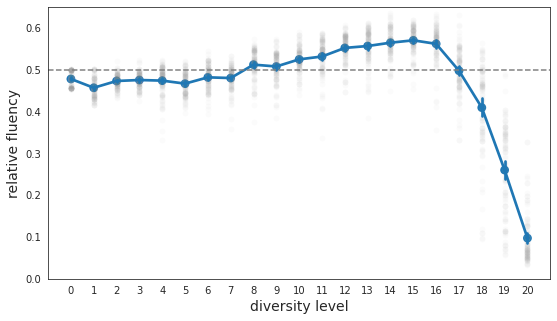

In [12]:
sns.set_style("white")
fig, ax = plt.subplots(ncols=1, figsize=(9, 5))
sns.pointplot(
    data=exp_1[exp_1["interaction_type"] == "strict"],
    x="diversity_level",
    y="fluency_ratio",
    ax=ax,
    legend=False,
)
sns.scatterplot(
    data=exp_1[exp_1["interaction_type"] == "strict"],
    x="diversity_level",
    y="fluency_ratio",
    alpha=0.03,
    ax=ax,
    legend=False,
    color="grey",
)
ax.set_xlabel("diversity level", fontsize=14)
ax.set_ylabel("relative fluency", fontsize=14)
ax.set_xticks(range(21), range(21))
ax.axhline(
    exp_1[exp_1["n_back"] == 0].fluency_ratio_individual.mean(),
    linestyle="--",
    color="grey",
)
ax.set_ylim(0, 0.65)
plt.savefig("../figures/fluency_exp1.png", dpi=300, bbox_inches="tight")
plt.show()

Let's plot exploration. As described in the paper, the `exploration index` is defined as the average jump between two consecutive animals.
During our preprocessing, we had labelled this variable "flexibility".

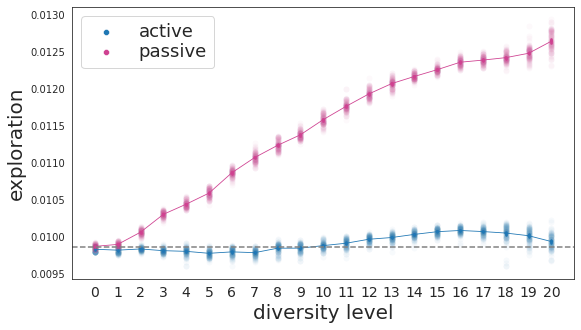

In [15]:
fig, ax = plt.subplots(figsize=(9, 5))
sns.pointplot(
    data=exp_1[exp_1["interaction_type"] == "strict"],
    x="diversity_level",
    y="flexibility_speaker",
    ax=ax,
    scale=0.3,
)
sns.scatterplot(
    data=exp_1[exp_1["interaction_type"] == "strict"],
    x="diversity_level",
    y="flexibility_speaker",
    alpha=0.03,
    ax=ax,
    label="active",
)
sns.pointplot(
    data=exp_1[exp_1["interaction_type"] == "strict"],
    x="diversity_level",
    y="flexibility_listener",
    ax=ax,
    color=sns.color_palette("PiYG")[0],
    scale=0.3,
)
sns.scatterplot(
    data=exp_1[exp_1["interaction_type"] == "strict"],
    x="diversity_level",
    y="flexibility_listener",
    alpha=0.03,
    ax=ax,
    label="passive",
    color=sns.color_palette("PiYG")[0],
)
ax.set_xlabel("diversity level", fontsize=20)
ax.set_ylabel("exploration", fontsize=20)
ax.set_xticks(range(21), range(21), fontsize=14)
ax.axhline(
    exp_1[exp_1["n_back"] == 0].flexibility_a0.mean(), linestyle="--", color="grey"
)
leg = ax.legend(fontsize=18, loc="upper left", labelspacing=0.1)
for lh in leg.legendHandles:
    lh.set_alpha(1)

plt.savefig("../figures/exploration_exp1.png", dpi=600, bbox_inches="tight")
plt.show()

Now let's plot the neighborhood density index. This is the average of the number of subthreshold neighbors that each animal named in the simulation has natively in the agent's semantic space.

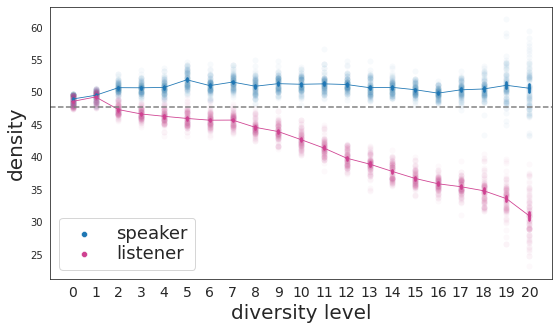

In [18]:
fig, ax = plt.subplots(nrows=1, figsize=(9, 5))

sns.pointplot(
    data=exp_1[exp_1["interaction_type"] == "strict"],
    x="diversity_level",
    y="resp_neighbors_speaker",
    ax=ax,
    scale=0.3,
)
sns.scatterplot(
    data=exp_1[exp_1["interaction_type"] == "strict"],
    x="diversity_level",
    y="resp_neighbors_speaker",
    alpha=0.03,
    ax=ax,
    label="speaker",
)
sns.pointplot(
    data=exp_1[exp_1["interaction_type"] == "strict"],
    x="diversity_level",
    y="resp_neighbors_listener",
    ax=ax,
    color=sns.color_palette("PiYG")[0],
    scale=0.3,
)
sns.scatterplot(
    data=exp_1[exp_1["interaction_type"] == "strict"],
    x="diversity_level",
    y="resp_neighbors_listener",
    alpha=0.03,
    ax=ax,
    label="listener",
    color=sns.color_palette("PiYG")[0],
)
ax.set_xlabel("diversity level", fontsize=20)
ax.set_ylabel("density", fontsize=20)
ax.set_xticks(range(21), range(21), fontsize=14)
leg = ax.legend(fontsize=18, labelspacing=0.1)
ax.axhline(47.6634, linestyle="--", color="grey")
for lh in leg.legendHandles:
    lh.set_alpha(1)
plt.savefig("../figures/density_exp1.png", dpi=600, bbox_inches="tight")
plt.show()

The following plot displays the correlation in densities across the two agents.

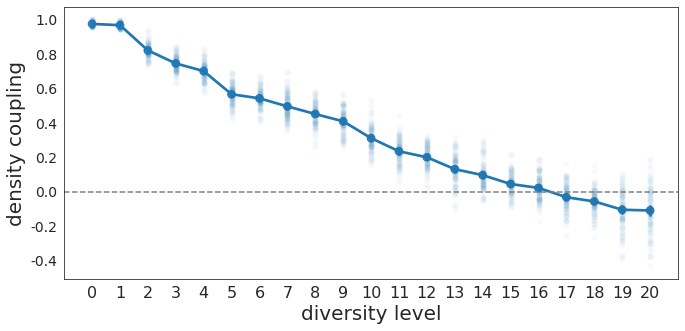

In [19]:
fig, ax = plt.subplots(nrows=1, figsize=(11, 5))
sns.pointplot(
    data=exp_1[exp_1["interaction_type"] == "strict"],
    x="diversity_level",
    y="resp_neighbors_cor",
    ax=ax,
)
sns.scatterplot(
    data=exp_1[exp_1["interaction_type"] == "strict"],
    x="diversity_level",
    y="resp_neighbors_cor",
    alpha=0.03,
    ax=ax,
)
ax.set_xlabel("diversity level", fontsize=20)
ax.set_ylabel("density coupling", fontsize=20)
ax.set_xticks(range(21), range(21), fontsize=16)
ax.set_yticks(
    np.arange(-0.4, 1.2, 0.2).round(1), np.arange(-0.4, 1.2, 0.2).round(1), fontsize=14
)
ax.axhline(0.0, linestyle="--", color="grey")
plt.savefig("../figures/density_cor_exp1.png", dpi=600, bbox_inches="tight")
plt.show()

Finally, we plot originality (here, we plot the mean between originality computed from the perspectives of each of the two agents.

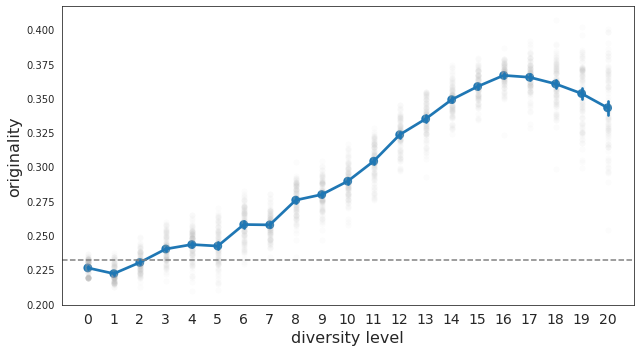

In [21]:
fig, ax = plt.subplots(nrows=1, figsize=(9, 5))

sns.pointplot(
    data=exp_1[exp_1["interaction_type"] == "strict"],
    x="diversity_level",
    y="orig_mean",
    ax=ax,
)
sns.scatterplot(
    data=exp_1[exp_1["interaction_type"] == "strict"],
    x="diversity_level",
    y="orig_mean",
    alpha=0.03,
    ax=ax,
    color="darkgrey",
)
ax.set_xlabel("diversity level", fontsize=16)
ax.set_ylabel("originality", fontsize=16)
ax.set_xticks(range(21), range(21), fontsize=14)
ax.axhline(
    exp_1[exp_1["n_back"] == 0].orig_a0_individual.mean(), linestyle="--", color="grey"
)
plt.tight_layout()
plt.savefig("../figures/originality_exp1.png", dpi=600, bbox_inches="tight")
plt.show()

### Experiment 2
In Experiment 2, we introduced multiple forms of turn-taking. The following plot aim to illustrate how performance and search strategies change as a function of this parameters. Let's start from renamed interaction_types to `strict`, `collaborative` and `competitive`, as labelled in the paper.

In [22]:
exp_2["interaction_type"] = exp_2["interaction_type"].map(
    {"strict": "strict", "flexible": "collaborative", "shortest": "competitive"}
)

/tmp/ipykernel_2506/82088218.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exp_2['interaction_type'] = exp_2['interaction_type'].map({'strict': 'strict', 'flexible': 'collaborative', 'shortest': 'competitive'})


The following plot displays fluency across the three conditions.

/home/coder/.local/lib/python3.9/site-packages/seaborn/relational.py:657: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  args = np.asarray(x), np.asarray(y), np.asarray(s), np.asarray(c)


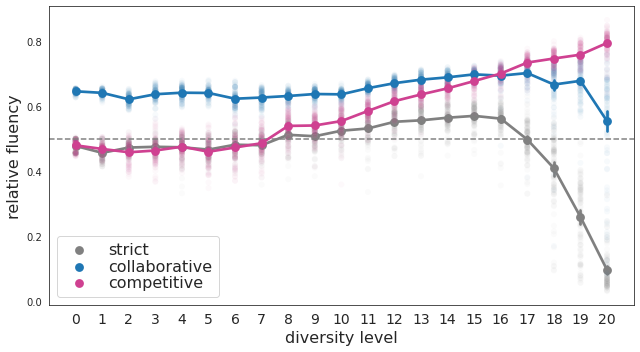

In [24]:
fig, ax = plt.subplots(nrows=1, figsize=(9, 5))

palette = ["grey", sns.color_palette()[0], sns.color_palette("PiYG")[0]]

sns.pointplot(
    data=exp_2,
    x="diversity_level",
    y="fluency_ratio",
    hue="interaction_type",
    ax=ax,
    palette=palette,
)
sns.scatterplot(
    data=exp_2,
    x="diversity_level",
    y="fluency_ratio",
    hue="interaction_type",
    alpha=0.03,
    ax=ax,
    palette=palette,
    legend=False,
)
ax.set_xlabel("diversity level", fontsize=16)
ax.set_ylabel("relative fluency", fontsize=16)
ax.set_xticks(range(21), range(21), fontsize=14)
ax.axhline(
    exp_2[exp_2["n_back"] == 0].fluency_ratio_individual.mean(),
    linestyle="--",
    color="grey",
)
leg = ax.legend(fontsize=16, labelspacing=0.1, loc="lower left")
for lh in leg.legendHandles:
    lh.set_alpha(1)
plt.tight_layout()
plt.savefig("../figures/fluency_exp2.png", dpi=600, bbox_inches="tight")
plt.show()

Next, we plot originality both from the perspective of the speaker and as an average between the two agents.

/home/coder/.local/lib/python3.9/site-packages/seaborn/relational.py:657: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  args = np.asarray(x), np.asarray(y), np.asarray(s), np.asarray(c)


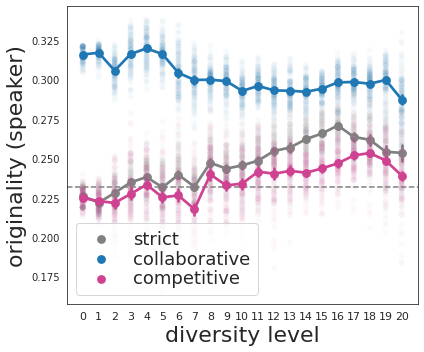

In [32]:
fig, ax = plt.subplots(nrows=1, figsize=(6, 5))
sns.pointplot(
    data=exp_2,
    x="diversity_level",
    y="orig_speaker",
    hue="interaction_type",
    ax=ax,
    palette=palette,
)
sns.scatterplot(
    data=exp_2,
    x="diversity_level",
    y="orig_speaker",
    hue="interaction_type",
    alpha=0.03,
    ax=ax,
    palette=palette,
    legend=False,
)
ax.set_xlabel("diversity level", fontsize=22)
ax.set_ylabel("originality (speaker)", fontsize=22)
ax.set_xticks(range(21), range(21), fontsize=11)
ax.axhline(
    exp_2[exp_2["n_back"] == 0].orig_a0_individual.mean(), linestyle="--", color="grey"
)
leg = ax.legend(fontsize=18, labelspacing=0.1, loc="lower left")
for lh in leg.legendHandles:
    lh.set_alpha(1)
plt.tight_layout()
plt.savefig("../figures/orig_speaker_exp2.png", dpi=600, bbox_inches="tight")
plt.show()

/home/coder/.local/lib/python3.9/site-packages/seaborn/relational.py:657: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  args = np.asarray(x), np.asarray(y), np.asarray(s), np.asarray(c)


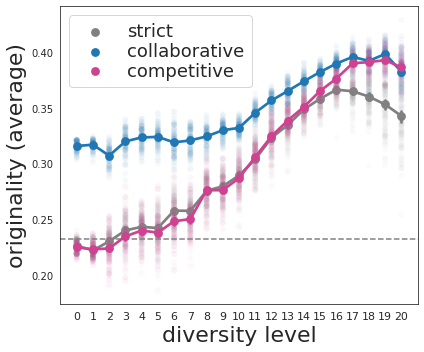

In [33]:
fig, ax = plt.subplots(nrows=1, figsize=(6, 5))
sns.pointplot(
    data=exp_2,
    x="diversity_level",
    y="orig_mean",
    hue="interaction_type",
    ax=ax,
    palette=palette,
)
sns.scatterplot(
    data=exp_2,
    x="diversity_level",
    y="orig_mean",
    hue="interaction_type",
    alpha=0.03,
    ax=ax,
    palette=palette,
    legend=False,
)
ax.set_xlabel("diversity level", fontsize=22)
ax.set_ylabel("originality (average)", fontsize=22)
ax.set_xticks(range(21), range(21), fontsize=11)
ax.axhline(
    exp_2[exp_2["n_back"] == 0].orig_a0_individual.mean(), linestyle="--", color="grey"
)
leg = ax.legend(fontsize=18, labelspacing=0.1, loc="upper left")
for lh in leg.legendHandles:
    lh.set_alpha(1)
plt.tight_layout()
plt.savefig("../figures/orig_exp2.png", dpi=600, bbox_inches="tight")
plt.show()

The following block visualizes active exploration indices for all conditions

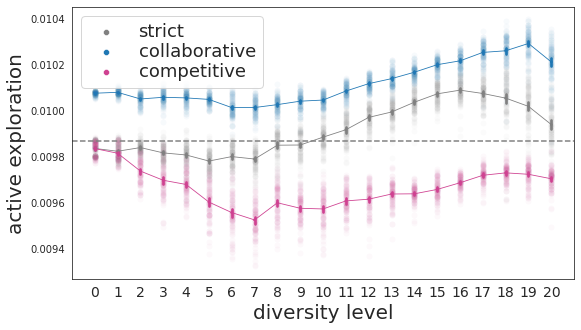

In [35]:
fig, ax = plt.subplots(figsize=(9, 5))

sns.pointplot(
    data=exp_2[exp_2["interaction_type"] == "strict"],
    x="diversity_level",
    y="flexibility_speaker",
    ax=ax,
    scale=0.3,
    color=palette[0],
)
sns.scatterplot(
    data=exp_2[exp_2["interaction_type"] == "strict"],
    x="diversity_level",
    y="flexibility_speaker",
    alpha=0.03,
    ax=ax,
    label="strict",
    color=palette[0],
)

sns.pointplot(
    data=exp_2[exp_2["interaction_type"] == "collaborative"],
    x="diversity_level",
    y="flexibility_speaker",
    ax=ax,
    scale=0.3,
    color=palette[1],
)
sns.scatterplot(
    data=exp_2[exp_2["interaction_type"] == "collaborative"],
    x="diversity_level",
    y="flexibility_speaker",
    alpha=0.03,
    ax=ax,
    label="collaborative",
    color=palette[1],
)

sns.pointplot(
    data=exp_2[exp_2["interaction_type"] == "competitive"],
    x="diversity_level",
    y="flexibility_speaker",
    ax=ax,
    scale=0.3,
    color=palette[2],
)
sns.scatterplot(
    data=exp_2[exp_2["interaction_type"] == "competitive"],
    x="diversity_level",
    y="flexibility_speaker",
    alpha=0.03,
    ax=ax,
    label="competitive",
    color=palette[2],
)


ax.set_xlabel("diversity level", fontsize=20)
ax.set_ylabel("active exploration", fontsize=20)
ax.set_xticks(range(21), range(21), fontsize=14)
ax.axhline(
    exp_2[exp_2["n_back"] == 0].flexibility_a0.mean(), linestyle="--", color="grey"
)
leg = ax.legend(fontsize=18, loc="upper left", labelspacing=0.1)
for lh in leg.legendHandles:
    lh.set_alpha(1)

plt.savefig("../figures/active_exploration_exp2.png", dpi=600, bbox_inches="tight")
plt.show()

The following block visualizes passive exploration indices for all conditions

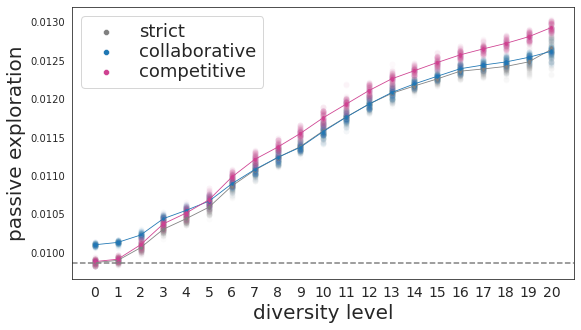

In [36]:
fig, ax = plt.subplots(figsize=(9, 5))

sns.pointplot(
    data=exp_2[exp_2["interaction_type"] == "strict"],
    x="diversity_level",
    y="flexibility_listener",
    ax=ax,
    scale=0.3,
    color=palette[0],
)
sns.scatterplot(
    data=exp_2[exp_2["interaction_type"] == "strict"],
    x="diversity_level",
    y="flexibility_listener",
    alpha=0.03,
    ax=ax,
    label="strict",
    color=palette[0],
)

sns.pointplot(
    data=exp_2[exp_2["interaction_type"] == "collaborative"],
    x="diversity_level",
    y="flexibility_listener",
    ax=ax,
    scale=0.3,
    color=palette[1],
)
sns.scatterplot(
    data=exp_2[exp_2["interaction_type"] == "collaborative"],
    x="diversity_level",
    y="flexibility_listener",
    alpha=0.03,
    ax=ax,
    label="collaborative",
    color=palette[1],
)

sns.pointplot(
    data=exp_2[exp_2["interaction_type"] == "competitive"],
    x="diversity_level",
    y="flexibility_listener",
    ax=ax,
    scale=0.3,
    color=palette[2],
)
sns.scatterplot(
    data=exp_2[exp_2["interaction_type"] == "competitive"],
    x="diversity_level",
    y="flexibility_listener",
    alpha=0.03,
    ax=ax,
    label="competitive",
    color=palette[2],
)


ax.set_xlabel("diversity level", fontsize=20)
ax.set_ylabel("passive exploration", fontsize=20)
ax.set_xticks(range(21), range(21), fontsize=14)
ax.axhline(
    exp_2[exp_2["n_back"] == 0].flexibility_a0.mean(), linestyle="--", color="grey"
)
leg = ax.legend(fontsize=18, loc="upper left", labelspacing=0.1)
for lh in leg.legendHandles:
    lh.set_alpha(1)

plt.savefig("../figures/passive_exploration_exp2.png", dpi=600, bbox_inches="tight")
plt.show()

Finally, we visualize neighborhood density from the speaker's perspective.

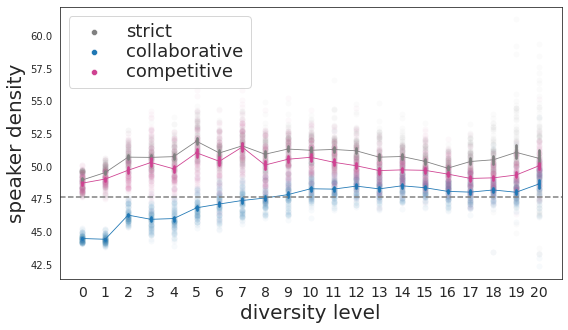

In [38]:
fig, ax = plt.subplots(nrows=1, figsize=(9, 5))

sns.pointplot(
    data=exp_2[exp_2["interaction_type"] == "strict"],
    x="diversity_level",
    y="resp_neighbors_speaker",
    ax=ax,
    scale=0.3,
    color=palette[0],
)
sns.scatterplot(
    data=exp_2[exp_2["interaction_type"] == "strict"],
    x="diversity_level",
    y="resp_neighbors_speaker",
    alpha=0.03,
    ax=ax,
    label="strict",
    color=palette[0],
)
sns.pointplot(
    data=exp_2[exp_2["interaction_type"] == "collaborative"],
    x="diversity_level",
    y="resp_neighbors_speaker",
    ax=ax,
    color=palette[1],
    scale=0.3,
)
sns.scatterplot(
    data=exp_2[exp_2["interaction_type"] == "collaborative"],
    x="diversity_level",
    y="resp_neighbors_speaker",
    alpha=0.03,
    ax=ax,
    label="collaborative",
    color=palette[1],
)
sns.pointplot(
    data=exp_2[exp_2["interaction_type"] == "competitive"],
    x="diversity_level",
    y="resp_neighbors_speaker",
    ax=ax,
    color=palette[2],
    scale=0.3,
)
sns.scatterplot(
    data=exp_2[exp_2["interaction_type"] == "competitive"],
    x="diversity_level",
    y="resp_neighbors_speaker",
    alpha=0.03,
    ax=ax,
    label="competitive",
    color=palette[2],
)
ax.set_xlabel("diversity level", fontsize=20)
ax.set_ylabel("speaker density", fontsize=20)
ax.set_xticks(range(21), range(21), fontsize=14)
leg = ax.legend(fontsize=18, labelspacing=0.1)
ax.axhline(47.6634, linestyle="--", color="grey")
for lh in leg.legendHandles:
    lh.set_alpha(1)
plt.savefig("../figures/speaker_density_exp2.png", dpi=600, bbox_inches="tight")
plt.show()

... and from the listener's perspective.

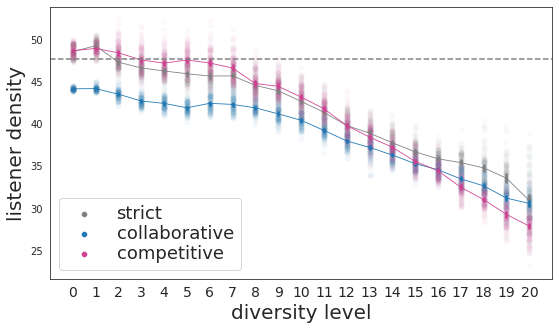

In [39]:
fig, ax = plt.subplots(nrows=1, figsize=(9, 5))

sns.pointplot(
    data=exp_2[exp_2["interaction_type"] == "strict"],
    x="diversity_level",
    y="resp_neighbors_listener",
    ax=ax,
    scale=0.3,
    color=palette[0],
)
sns.scatterplot(
    data=exp_2[exp_2["interaction_type"] == "strict"],
    x="diversity_level",
    y="resp_neighbors_listener",
    alpha=0.03,
    ax=ax,
    label="strict",
    color=palette[0],
)
sns.pointplot(
    data=exp_2[exp_2["interaction_type"] == "collaborative"],
    x="diversity_level",
    y="resp_neighbors_listener",
    ax=ax,
    color=palette[1],
    scale=0.3,
)
sns.scatterplot(
    data=exp_2[exp_2["interaction_type"] == "collaborative"],
    x="diversity_level",
    y="resp_neighbors_listener",
    alpha=0.03,
    ax=ax,
    label="collaborative",
    color=palette[1],
)
sns.pointplot(
    data=exp_2[exp_2["interaction_type"] == "competitive"],
    x="diversity_level",
    y="resp_neighbors_listener",
    ax=ax,
    color=palette[2],
    scale=0.3,
)
sns.scatterplot(
    data=exp_2[exp_2["interaction_type"] == "competitive"],
    x="diversity_level",
    y="resp_neighbors_listener",
    alpha=0.03,
    ax=ax,
    label="competitive",
    color=palette[2],
)
ax.set_xlabel("diversity level", fontsize=20)
ax.set_ylabel("listener density", fontsize=20)
ax.set_xticks(range(21), range(21), fontsize=14)
leg = ax.legend(fontsize=18, labelspacing=0.1)
ax.axhline(47.6634, linestyle="--", color="grey")
for lh in leg.legendHandles:
    lh.set_alpha(1)
plt.savefig("../figures/listener_density_exp2.png", dpi=600, bbox_inches="tight")
plt.show()

### Experiment 3
In experiment 3, we added an additional manipulation for cognitive flexibility.
Alongside multiple interaction protocols, we allow agents to revert to previous prompts if no sub-threshold association is available.
Let's visualize the results.

First, let's rename interaction protocols as we have done previously.

In [40]:
exp_3["interaction_type"] = exp_3["interaction_type"].map(
    {"strict": "strict", "flexible": "collaborative", "shortest": "competitive"}
)

Let's plot fluency for all agents, across interaction protocols and n-back conditions.

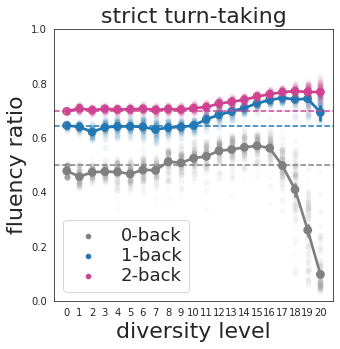

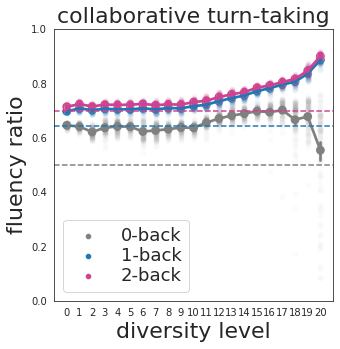

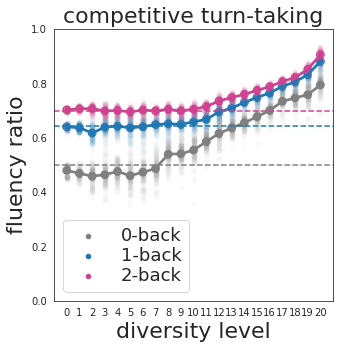

In [41]:
for c in ["strict", "collaborative", "competitive"]:
    fig, ax = plt.subplots(figsize=(5, 5))

    sns.pointplot(
        data=exp_3[(exp_3["interaction_type"] == c) & (exp_3["n_back"] == 0)],
        x="diversity_level",
        y="fluency_ratio",
        ax=ax,
        color=palette[0],
    )
    sns.scatterplot(
        data=exp_3[(exp_3["interaction_type"] == c) & (exp_3["n_back"] == 0)],
        x="diversity_level",
        y="fluency_ratio",
        ax=ax,
        alpha=0.03,
        label="0-back",
        color=palette[0],
    )

    sns.pointplot(
        data=exp_3[(exp_3["interaction_type"] == c) & (exp_3["n_back"] == 1)],
        x="diversity_level",
        y="fluency_ratio",
        ax=ax,
        color=palette[1],
    )
    sns.scatterplot(
        data=exp_3[(exp_3["interaction_type"] == c) & (exp_3["n_back"] == 1)],
        x="diversity_level",
        y="fluency_ratio",
        alpha=0.03,
        ax=ax,
        label="1-back",
        color=palette[1],
    )

    sns.pointplot(
        data=exp_3[(exp_3["interaction_type"] == c) & (exp_3["n_back"] == 2)],
        x="diversity_level",
        y="fluency_ratio",
        ax=ax,
        color=palette[2],
    )
    sns.scatterplot(
        data=exp_3[(exp_3["interaction_type"] == c) & (exp_3["n_back"] == 2)],
        x="diversity_level",
        y="fluency_ratio",
        alpha=0.03,
        ax=ax,
        label="2-back",
        color=palette[2],
    )

    ax.set_xlabel("diversity level", fontsize=22)
    ax.set_ylabel("fluency ratio", fontsize=22)
    ax.set_xticks(range(21), range(21), fontsize=10)
    ax.set_ylim(0.0, 1.0)
    ax.set_title(f"{c} turn-taking", fontsize=22)
    for n in range(3):
        ax.axhline(
            exp_3[exp_3["n_back"] == n].fluency_ratio_individual.mean(),
            linestyle="--",
            color=palette[n],
        )
    leg = ax.legend(fontsize=18, loc="lower left", labelspacing=0.1)
    for lh in leg.legendHandles:
        lh.set_alpha(1)

    plt.savefig(f"../figures/fluency_{c}_exp3.png", dpi=600, bbox_inches="tight")
    plt.show()

Secondly, let's plot originality (focusing on average originality across the two agents)

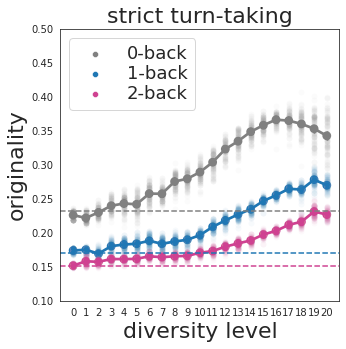

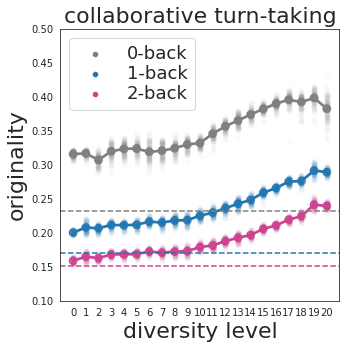

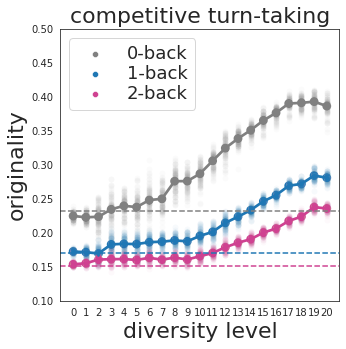

In [43]:
for c in ["strict", "collaborative", "competitive"]:
    fig, ax = plt.subplots(figsize=(5, 5))

    sns.pointplot(
        data=exp_3[(exp_3["interaction_type"] == c) & (exp_3["n_back"] == 0)],
        x="diversity_level",
        y="orig_mean",
        ax=ax,
        color=palette[0],
    )
    sns.scatterplot(
        data=exp_3[(exp_3["interaction_type"] == c) & (exp_3["n_back"] == 0)],
        x="diversity_level",
        y="orig_mean",
        alpha=0.03,
        ax=ax,
        label="0-back",
        color=palette[0],
    )

    sns.pointplot(
        data=exp_3[(exp_3["interaction_type"] == c) & (exp_3["n_back"] == 1)],
        x="diversity_level",
        y="orig_mean",
        ax=ax,
        color=palette[1],
    )
    sns.scatterplot(
        data=exp_3[(exp_3["interaction_type"] == c) & (exp_3["n_back"] == 1)],
        x="diversity_level",
        y="orig_mean",
        alpha=0.03,
        ax=ax,
        label="1-back",
        color=palette[1],
    )

    sns.pointplot(
        data=exp_3[(exp_3["interaction_type"] == c) & (exp_3["n_back"] == 2)],
        x="diversity_level",
        y="orig_mean",
        ax=ax,
        color=palette[2],
    )
    sns.scatterplot(
        data=exp_3[(exp_3["interaction_type"] == c) & (exp_3["n_back"] == 2)],
        x="diversity_level",
        y="orig_mean",
        alpha=0.03,
        ax=ax,
        label="2-back",
        color=palette[2],
    )

    ax.set_xlabel("diversity level", fontsize=22)
    ax.set_title(f"{c} turn-taking", fontsize=22)
    ax.set_ylabel("originality", fontsize=22)
    ax.set_xticks(range(21), range(21), fontsize=10)
    ax.set_ylim(0.1, 0.5)
    for n in range(3):
        ax.axhline(
            exp_3[
                (exp_3["n_back"] == n) & (exp_3["interaction_type"] == c)
            ].orig_a0_individual.mean(),
            linestyle="--",
            color=palette[n],
        )
    leg = ax.legend(fontsize=18, loc="upper left", labelspacing=0.1)
    for lh in leg.legendHandles:
        lh.set_alpha(1)

    plt.savefig(f"../figures/orig_{c}_exp3.png", dpi=600, bbox_inches="tight")
    plt.show()

The next two blocks focus on exploration indices from the listener's and the speaker's perspective respectively

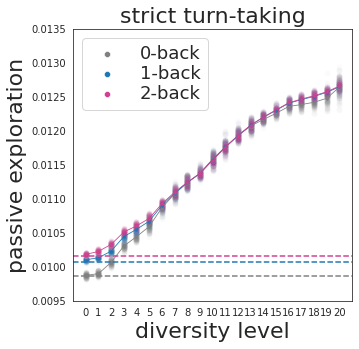

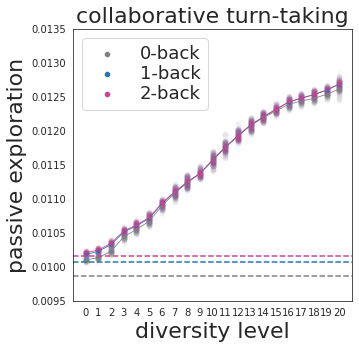

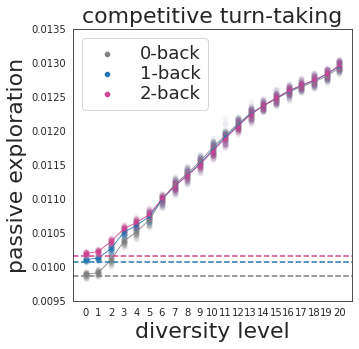

In [45]:
for c in ["strict", "collaborative", "competitive"]:
    fig, ax = plt.subplots(figsize=(5, 5))

    sns.pointplot(
        data=exp_3[(exp_3["interaction_type"] == c) & (exp_3["n_back"] == 0)],
        x="diversity_level",
        y="flexibility_listener",
        ax=ax,
        scale=0.3,
        color=palette[0],
    )
    sns.scatterplot(
        data=exp_3[(exp_3["interaction_type"] == c) & (exp_3["n_back"] == 0)],
        x="diversity_level",
        y="flexibility_listener",
        alpha=0.03,
        ax=ax,
        label="0-back",
        color=palette[0],
    )

    sns.pointplot(
        data=exp_3[(exp_3["interaction_type"] == c) & (exp_3["n_back"] == 1)],
        x="diversity_level",
        y="flexibility_listener",
        ax=ax,
        scale=0.3,
        color=palette[1],
    )
    sns.scatterplot(
        data=exp_3[(exp_3["interaction_type"] == c) & (exp_3["n_back"] == 1)],
        x="diversity_level",
        y="flexibility_listener",
        alpha=0.03,
        ax=ax,
        label="1-back",
        color=palette[1],
    )

    sns.pointplot(
        data=exp_3[(exp_3["interaction_type"] == c) & (exp_3["n_back"] == 2)],
        x="diversity_level",
        y="flexibility_listener",
        ax=ax,
        scale=0.3,
        color=palette[2],
    )
    sns.scatterplot(
        data=exp_3[(exp_3["interaction_type"] == c) & (exp_3["n_back"] == 2)],
        x="diversity_level",
        y="flexibility_listener",
        alpha=0.03,
        ax=ax,
        label="2-back",
        color=palette[2],
    )

    ax.set_xlabel("diversity level", fontsize=22)
    ax.set_title(f"{c} turn-taking", fontsize=22)
    ax.set_ylabel("passive exploration", fontsize=22)
    ax.set_xticks(range(21), range(21), fontsize=10)
    ax.set_ylim(0.0095, 0.0135)
    for n in range(3):
        ax.axhline(
            exp_3[
                (exp_3["n_back"] == n) & (exp_3["interaction_type"] == c)
            ].flexibility_a0.mean(),
            linestyle="--",
            color=palette[n],
        )
    leg = ax.legend(fontsize=18, loc="upper left", labelspacing=0.1)
    for lh in leg.legendHandles:
        lh.set_alpha(1)

    plt.savefig(
        f"../figures/passive_exploration_{c}_exp3.png", dpi=600, bbox_inches="tight"
    )
    plt.show()

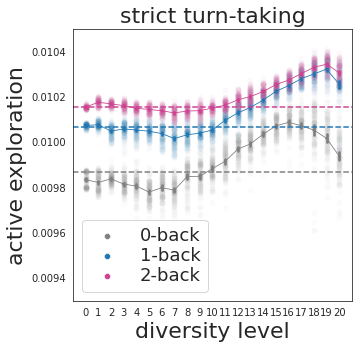

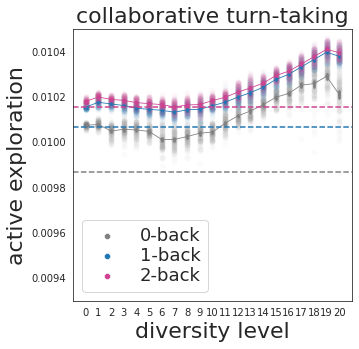

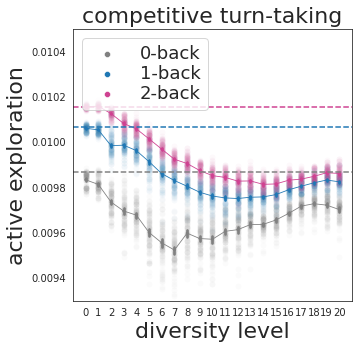

In [46]:
for c in ["strict", "collaborative", "competitive"]:
    fig, ax = plt.subplots(figsize=(5, 5))

    sns.pointplot(
        data=exp_3[(exp_3["interaction_type"] == c) & (exp_3["n_back"] == 0)],
        x="diversity_level",
        y="flexibility_speaker",
        ax=ax,
        scale=0.3,
        color=palette[0],
    )
    sns.scatterplot(
        data=exp_3[(exp_3["interaction_type"] == c) & (exp_3["n_back"] == 0)],
        x="diversity_level",
        y="flexibility_speaker",
        alpha=0.03,
        ax=ax,
        label="0-back",
        color=palette[0],
    )

    sns.pointplot(
        data=exp_3[(exp_3["interaction_type"] == c) & (exp_3["n_back"] == 1)],
        x="diversity_level",
        y="flexibility_speaker",
        ax=ax,
        scale=0.3,
        color=palette[1],
    )
    sns.scatterplot(
        data=exp_3[(exp_3["interaction_type"] == c) & (exp_3["n_back"] == 1)],
        x="diversity_level",
        y="flexibility_speaker",
        alpha=0.03,
        ax=ax,
        label="1-back",
        color=palette[1],
    )

    sns.pointplot(
        data=exp_3[(exp_3["interaction_type"] == c) & (exp_3["n_back"] == 2)],
        x="diversity_level",
        y="flexibility_speaker",
        ax=ax,
        scale=0.3,
        color=palette[2],
    )
    sns.scatterplot(
        data=exp_3[(exp_3["interaction_type"] == c) & (exp_3["n_back"] == 2)],
        x="diversity_level",
        y="flexibility_speaker",
        alpha=0.03,
        ax=ax,
        label="2-back",
        color=palette[2],
    )

    ax.set_xlabel("diversity level", fontsize=22)
    ax.set_title(f"{c} turn-taking", fontsize=22)
    ax.set_ylabel("active exploration", fontsize=22)
    ax.set_xticks(range(21), range(21), fontsize=10)
    ax.set_ylim(0.0093, 0.0105)
    for n in range(3):
        ax.axhline(
            exp_3[
                (exp_3["n_back"] == n) & (exp_3["interaction_type"] == c)
            ].flexibility_a0.mean(),
            linestyle="--",
            color=palette[n],
        )
    if c == "competitive":
        leg = ax.legend(fontsize=18, loc="upper left", labelspacing=0.1)
    else:
        leg = ax.legend(fontsize=18, loc="lower left", labelspacing=0.1)
    for lh in leg.legendHandles:
        lh.set_alpha(1)
    plt.savefig(
        f"../figures/active_exploration_{c}_exp3.png", dpi=600, bbox_inches="tight"
    )
    plt.show()

Now we extract neighborhood density indices for all agents, across all conditions, first from the speaker's perspective (*active*) then from the listener's perspective (*passive*)

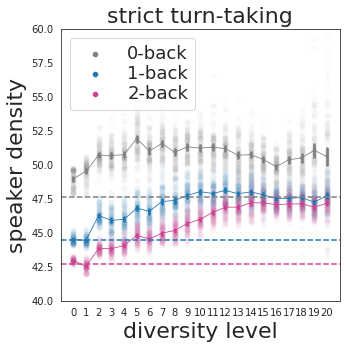

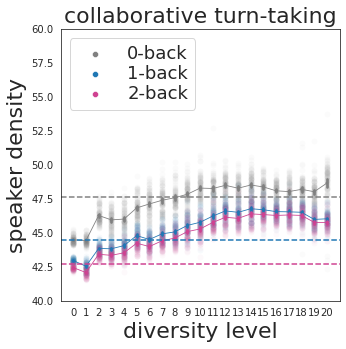

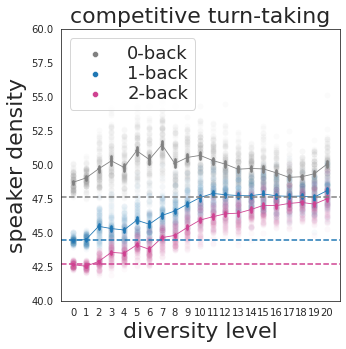

In [47]:
densities = [
    47.66349831138168,
    44.498336095738544,
    42.695931508001145,
]  # we extracted these at the beginning of this notebook
for c in ["strict", "collaborative", "competitive"]:
    fig, ax = plt.subplots(figsize=(5, 5))

    sns.pointplot(
        data=exp_3[(exp_3["interaction_type"] == c) & (exp_3["n_back"] == 0)],
        x="diversity_level",
        y="resp_neighbors_speaker",
        ax=ax,
        scale=0.3,
        color=palette[0],
    )
    sns.scatterplot(
        data=exp_3[(exp_3["interaction_type"] == c) & (exp_3["n_back"] == 0)],
        x="diversity_level",
        y="resp_neighbors_speaker",
        alpha=0.03,
        ax=ax,
        label="0-back",
        color=palette[0],
    )

    sns.pointplot(
        data=exp_3[(exp_3["interaction_type"] == c) & (exp_3["n_back"] == 1)],
        x="diversity_level",
        y="resp_neighbors_speaker",
        ax=ax,
        scale=0.3,
        color=palette[1],
    )
    sns.scatterplot(
        data=exp_3[(exp_3["interaction_type"] == c) & (exp_3["n_back"] == 1)],
        x="diversity_level",
        y="resp_neighbors_speaker",
        alpha=0.03,
        ax=ax,
        label="1-back",
        color=palette[1],
    )

    sns.pointplot(
        data=exp_3[(exp_3["interaction_type"] == c) & (exp_3["n_back"] == 2)],
        x="diversity_level",
        y="resp_neighbors_speaker",
        ax=ax,
        scale=0.3,
        color=palette[2],
    )
    sns.scatterplot(
        data=exp_3[(exp_3["interaction_type"] == c) & (exp_3["n_back"] == 2)],
        x="diversity_level",
        y="resp_neighbors_speaker",
        alpha=0.03,
        ax=ax,
        label="2-back",
        color=palette[2],
    )

    ax.set_xlabel("diversity level", fontsize=22)
    ax.set_title(f"{c} turn-taking", fontsize=22)
    ax.set_ylabel("speaker density", fontsize=22)
    ax.set_xticks(range(21), range(21), fontsize=10)
    ax.set_ylim(40, 60)
    for n in range(3):
        ax.axhline(densities[n], linestyle="--", color=palette[n])
    leg = ax.legend(fontsize=18, loc="upper left", labelspacing=0.1)
    for lh in leg.legendHandles:
        lh.set_alpha(1)
    plt.savefig(
        f"../figures/speaker_density_{c}_exp3.png", dpi=600, bbox_inches="tight"
    )
    plt.show()

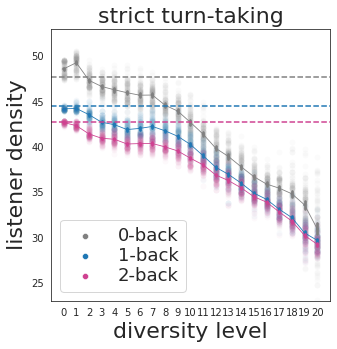

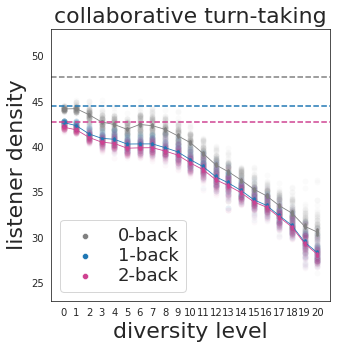

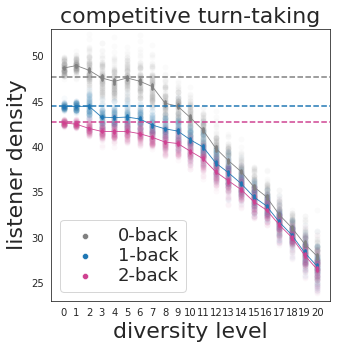

In [48]:
densities = [47.66349831138168, 44.498336095738544, 42.695931508001145]
for c in ["strict", "collaborative", "competitive"]:
    fig, ax = plt.subplots(figsize=(5, 5))

    sns.pointplot(
        data=exp_3[(exp_3["interaction_type"] == c) & (exp_3["n_back"] == 0)],
        x="diversity_level",
        y="resp_neighbors_listener",
        ax=ax,
        scale=0.3,
        color=palette[0],
    )
    sns.scatterplot(
        data=exp_3[(exp_3["interaction_type"] == c) & (exp_3["n_back"] == 0)],
        x="diversity_level",
        y="resp_neighbors_listener",
        alpha=0.03,
        ax=ax,
        label="0-back",
        color=palette[0],
    )

    sns.pointplot(
        data=exp_3[(exp_3["interaction_type"] == c) & (exp_3["n_back"] == 1)],
        x="diversity_level",
        y="resp_neighbors_listener",
        ax=ax,
        scale=0.3,
        color=palette[1],
    )
    sns.scatterplot(
        data=exp_3[(exp_3["interaction_type"] == c) & (exp_3["n_back"] == 1)],
        x="diversity_level",
        y="resp_neighbors_listener",
        alpha=0.03,
        ax=ax,
        label="1-back",
        color=palette[1],
    )

    sns.pointplot(
        data=exp_3[(exp_3["interaction_type"] == c) & (exp_3["n_back"] == 2)],
        x="diversity_level",
        y="resp_neighbors_listener",
        ax=ax,
        scale=0.3,
        color=palette[2],
    )
    sns.scatterplot(
        data=exp_3[(exp_3["interaction_type"] == c) & (exp_3["n_back"] == 2)],
        x="diversity_level",
        y="resp_neighbors_listener",
        alpha=0.03,
        ax=ax,
        label="2-back",
        color=palette[2],
    )

    ax.set_xlabel("diversity level", fontsize=22)
    ax.set_title(f"{c} turn-taking", fontsize=22)
    ax.set_ylabel("listener density", fontsize=22)
    ax.set_xticks(range(21), range(21), fontsize=10)
    ax.set_ylim(23, 53)
    for n in range(3):
        ax.axhline(densities[n], linestyle="--", color=palette[n])
    leg = ax.legend(fontsize=18, loc="lower left", labelspacing=0.1)
    for lh in leg.legendHandles:
        lh.set_alpha(1)
    plt.savefig(
        f"../figures/listener_density_{c}_exp3.png", dpi=600, bbox_inches="tight"
    )
    plt.show()